## Visualizing What Kernel Sees

This assignment focusses on using gradCAM to visualize what kernel sees to predict output

### Import necessary modules

In [2]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 

from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

#### Visualzing dataset

* Its very important to visualize that dataset to understand the complexity of features the network should learn
* It also helps in understanding what sort of image augmentation should be applied to the datasets

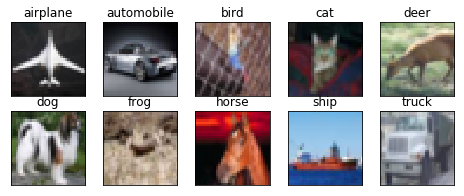

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

#### Helper functions

* Following are helper functions to understand how network performed
* It plots graph on model accuracy and loss for training vs validation dataset over increasing epochs

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

#### Pixel Normalization

* It is good to rescale dataset, so that network sees image in same range and hence makes it easy to learn

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

#### Network architecure 

We design the network by making the following considerations:
  * No Dropout in last layer
  * Remove Dense layers
  * Have network with alternating high channels & low channels (squeeze & excite)
  * Add Batch Normalization
  * Add Image Normalization
  * Add Image Augmentation

In [8]:
# Define the model

dropout_val = 0.1
conv_start_size = 64

def Conv_Block(model, num_channels):
  model.add(Convolution2D(num_channels, 3, 3, border_mode='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu')) 
  model.add(Dropout(dropout_val))
  model.add(Convolution2D(2*num_channels, 3, 3, border_mode='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout_val))
  
def Transition_Block(model, num_channels):
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Convolution2D(num_channels, 1, 1))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout_val))


model = Sequential()
model.add(Convolution2D(conv_start_size, 3, 3, border_mode='same', input_shape=(32, 32, 3))) # Output: 32x32x64
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(Dropout(dropout_val))

Conv_Block(model, conv_start_size) # 32x32x128
Transition_Block(model, conv_start_size) # 16x16x64

Conv_Block(model, conv_start_size) # 16x16x128
Transition_Block(model, conv_start_size) # 8x8x64

Conv_Block(model, conv_start_size) # 8x8x128
Transition_Block(model, conv_start_size) # 4x4x64

Conv_Block(model, conv_start_size) # 4x4x128
Transition_Block(model, conv_start_size) # 2x2x64

model.add(Convolution2D(10, 2, 2)) # Output: 1x1x10

model.add(Flatten())
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



W0628 11:07:46.776127 139666923444096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
W0628 11:07:46.794791 139666923444096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0628 11:07:46.797351 139666923444096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0628 11:07:46.824511 139666923444096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
__________

### Load trained weights if you have any, rather than running the model again

In [0]:
import requests 
weights_url = "https://drive.google.com/uc?export=download&id=1iWJx4FiyxEZd-VAWyD8YGnrjuuPl0zFW"
  
r = requests.get(weights_url) 
  
with open("assignment_9_best_weights.hdf5",'wb') as f: 
    f.write(r.content) 

model.load_weights("assignment_9_best_weights.hdf5")

#### Run the  network if not trained weights available and examine output

* Gives accuracy of 88.49

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
W0628 09:28:12.636210 140564777781120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a futur

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 37s 95ms/step - loss: 1.6245 - acc: 0.4043 - val_loss: 2.0964 - val_acc: 0.2935

Epoch 00001: val_acc improved from -inf to 0.29350, saving model to best_weights.hdf5
Epoch 2/100
390/390 [==============================] - 31s 80ms/step - loss: 1.1972 - acc: 0.5698 - val_loss: 1.1367 - val_acc: 0.5932

Epoch 00002: val_acc improved from 0.29350 to 0.59320, saving model to best_weights.hdf5
Epoch 3/100
390/390 [==============================] - 30s 78ms/step - loss: 0.9634 - acc: 0.6595 - val_loss: 1.0971 - val_acc: 0.6104

Epoch 00003: val_acc improved from 0.59320 to 0.61040, saving model to best_weights.hdf5
Epoch 4/100
390/390 [==============================] - 31s 78ms/step - loss: 0.8328 - acc: 0.7052 - val_loss: 0.9300 - val_acc: 0.6677

Epoch 00004: val_acc improved from 0.61040 to 0.66770, saving model to best_weights.hdf5
Epoch 5/100
390/390 [==============================] - 36s 92ms/step - loss: 0.7530 - acc: 0.7361 - val_loss: 0.943

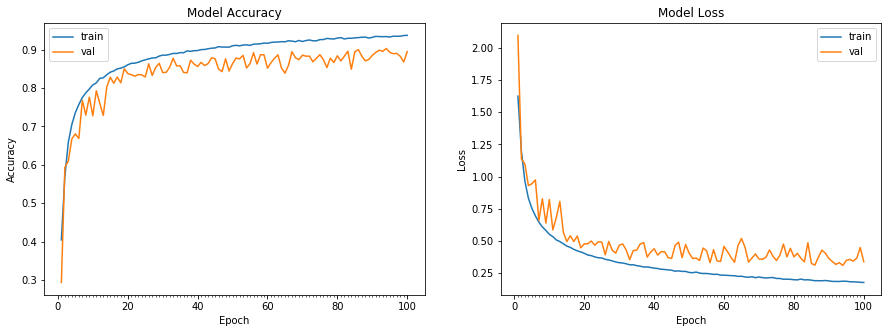

Accuracy on test data is: 89.49


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

checkpoint = ModelCheckpoint("assignment_9_best_weights.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1,
                                 callbacks=[checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

### Save the model weights
* Better to save the model weights
* Following downloads it to your local computer
* You can upload it to Google Drive and give downloadable link

In [0]:
from google.colab import files
files.download("assignment_9_best_weights.hdf5")

### gradCAM to visualize Class Activation Maps

In [0]:
import cv2
import keras.backend as K

def gradCAM(model, img, layer_name):
    # expand axis so that it can be passed as input to model
    # i.e from 32x32x3 -> 1x32x32x3
    x = np.expand_dims(img, axis=0)
    
    # Fetch top prediction of the image
    # Also fetch output from last convolution layer
    # Resulting feature map will be of shape same as layer's kernel shape
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer(layer_name)
   
    # Fetch gradient from last layer
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    
    # Perform Global Average Pooling (GAP)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    # Iterate through all channels and merge them
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(last_conv_layer.kernel.shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # Average the feature maps along channel dimension resulting in
    # heatmp of size same as kernel size of layer in consideration
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    
    # Normalize heatmap
    heatmap /= np.max(heatmap)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(np.uint8(255 * img), 0.6, heatmap, 0.4, 0)
 
    return superimposed_img

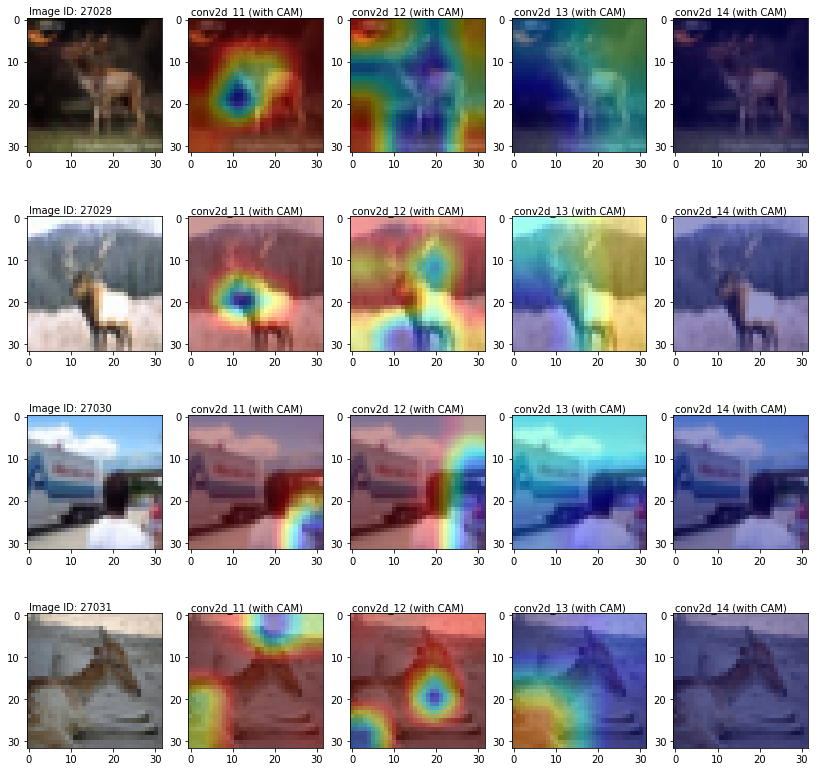

In [76]:
from matplotlib import pyplot as plt
%matplotlib inline

# Layers of which CAM is required
conv_layers = ["conv2d_11", "conv2d_12", "conv2d_13", "conv2d_14"]
# Number of images to be used in visualization
num_images = 4


fig=plt.figure(figsize=(14, 14))
columns = 1 + len(conv_layers)
rows = num_images

# Pick 4 images from a random start index
img_id = np.random.randint(train_features.shape[0] - num_images)

placeHolderId = 0
while placeHolderId < rows*columns:
    # Original Image
    placeHolderId += 1
    fig.add_subplot(rows, columns, placeHolderId)
    img = train_features[img_id]
    plt.imshow(img)
    annotation = "Image ID: " + str(img_id)
    plt.annotate(annotation, xy=(0,0), xytext=(0,-1.2), fontsize=10)
    
    for layer_name in conv_layers:
      # gradCAM Imposed Image
      placeHolderId += 1
      superimposed_img = gradCAM(model, img, layer_name)
      fig.add_subplot(rows, columns, placeHolderId)
      plt.imshow(superimposed_img)
      annotation = layer_name + " (with CAM)"
      plt.annotate(annotation, xy=(0,0), xytext=(0,-1.2), fontsize=10)

    img_id += 1

plt.show()